**Deep Q-Network (DQN) Agent**

**Note: Dueling DQN**

A `QNetwork` is used to model $Q(s,a)$. A `DuelingQNetwork` is an enhancement to the `QNetwork` architecture that separates $Q(s,a) = V(s) + A(s,a)$ into two streams to predict state values $V(s)$ and action advantages $A(s,a)$ (how action $a$ compares to other actions in state $s$). Note: To ensure that $A$ is centered around 0/avoid redundant information/etc., we use $Q(s,a) = V(s) + (A(s,a) - \text{mean}_{a}A(s,a))$.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    """ A Deep Q-Network """

    def __init__(self, n_obs_dim: int, n_action_dim: int, n_hidden_1_dim=64, n_hidden_2_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(n_obs_dim, n_hidden_1_dim)
        self.fc2 = nn.Linear(n_hidden_1_dim, n_hidden_2_dim)

        # Dueling DQN:
        
        # value stream
        self.value_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, 1)
        )
        
        # advantage stream
        self.advantage_stream = nn.Sequential(
            nn.Linear(n_hidden_2_dim, n_action_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # V(s)
        value = self.value_stream(x)

        # A(s,a)
        advantage = self.advantage_stream(x)
        
        # Q(s,a) = V(s) + A(s,a)
        Q_value = value + (advantage - advantage.mean(dim=1, keepdim=True))

        return Q_value

In [2]:
import random
from collections import deque
import numpy as np

from typing import *

class ReplayBuffer:
    """ A Replay Buffer """

    def __init__(self, buffer_size: int, batch_size: int):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        
        experiences = random.sample(self.memory, k=self.batch_size) # randomly (not sequentially because markov property) sample k experiences from memory
        # note: this is off-policy since the agent is learning from different versions of the policy

        states, actions, rewards, next_states, dones = zip(*experiences)

        states = torch.tensor(np.array(states), dtype=torch.float32)
        actions = torch.tensor(np.array(actions), dtype=torch.int64)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float32)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones = torch.tensor(np.array(dones), dtype=torch.float32)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

**Deep Q-Network (DQN)**

The goal is to model the Q-value function
$$
Q(s, a) = \mathbb{E}[r + \gamma \max_{a'} Q(s', a') | s, a]
$$

We achieve this by minimizing the loss between the target Q-value function and the local Q-value function
$$
\mathcal{L}(\theta) = \mathbb{E} \left[ (Q_{\text{target}} - Q(s, a; \theta))^2 \right]
$$

Where
- $Q_{\text{target}} = $ `reward` + $(\gamma \cdot Q_{\text{next}} \cdot (1 - $ `done`$))$
- $Q(s, a; \theta)$ is the existing Q-value function


Overall, the network update is performed using gradient descent:

$$
\theta \leftarrow \theta - \alpha \nabla_\theta \mathcal{L}(\theta)
$$


**Note: Double DQN**

Double DQN improves upon standard DQN by using the policy network for action selection and the target network for action evaluation, reducing overestimation bias in Q-value estimates.

In [3]:
import torch.optim as optim

class Agent:
    """ A Deep Q-Network (DQN) Agent """
    
    def __init__(self, obs_space: int, act_space: int, buffer_size=10000, batch_size=64):

        # set hyperparameters
        self.alpha = 1e-3       # learning rate
        self.gamma = 0.99       # discount factor
        self.tau = 1e-3         # soft update coefficient

        # epsilon-greedy exploration
        self.eps = 1.0
        self.eps_min = 0.01
        self.eps_decay = 0.995

        # temporal difference
        self.count = 0
        self.delay = 4

         # initialize policy
        self.memory = ReplayBuffer(buffer_size, batch_size)

        # reference: https://huggingface.co/learn/deep-rl-course/en/unit3/deep-q-algorithm#fixed-q
        self.QNetwork_local = DuelingQNetwork(obs_space, act_space)
        self.QNetwork_target = DuelingQNetwork(obs_space, act_space)

        self.optimizer = optim.AdamW(self.QNetwork_local.parameters(), lr=self.alpha)
        self.criterion = nn.MSELoss()

        # ensure same
        self.tau = 1.0 # lazy so yes
        self.soft_update()
        self.tau = 1e-3

    def step(self, state: np.ndarray, action: int, reward: float, next_state: np.ndarray, done: bool) -> None:
        
        # save to replay buffer
        self.memory.add((state, action, reward, next_state, done))

        # learn after specified number of steps (temporal difference)
        self.count = (self.count + 1) % self.delay
        if (self.count == 0) and (len(self.memory) > self.memory.batch_size):
            self.learn()

    def act(self, state: np.ndarray) -> int:
        state = torch.from_numpy(state).float().unsqueeze(0)

        # apply model to state
        with torch.no_grad():
            self.QNetwork_local.eval()
            Q_values = self.QNetwork_local(state)
            self.QNetwork_local.train()

        # select action
        if random.random() < self.eps:
            return random.choice(np.arange(self.QNetwork_local.advantage_stream[0].out_features)) # exploration
        else:
            return np.argmax(Q_values.numpy()) # exploitation

    def learn(self) -> None:
        """
        Update the QNetwork using experiences randomly sampled from ReplayBuffer.
        """

        # sample memory
        states, actions, rewards, next_states, dones = self.memory.sample()
        actions = actions.unsqueeze(1)

        # DDQN: use local network for action selection to reduce overestimation bias
        # reference: https://stats.stackexchange.com/questions/277442/why-does-q-learning-overestimate-action-values
        next_actions = self.QNetwork_local(next_states).detach().max(1)[1].unsqueeze(1)
        Q_targets_next = self.QNetwork_target(next_states).gather(1, next_actions).detach()

        # Q_target
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))

        # Q(s,a;θ)
        Q_expected = self.QNetwork_local(states).gather(1, actions)

        # compute loss: L(θ) = (Q_target - Q(s,a;θ))^2
        loss = self.criterion(Q_expected, Q_targets)
        
        # perform gradient descent (usual training process)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update()

        # decay epsilon
        self.eps = max(self.eps_min, self.eps * self.eps_decay)

    def soft_update(self) -> None:
        """ θ_target ← τ * θ_local + (1 - τ) * θ_target """

        # weighted update of the parameters of the target network from the parameters of the policy network
        for param_target, param_local in zip(self.QNetwork_target.parameters(), self.QNetwork_local.parameters()):
            param_target.data.copy_(self.tau * param_local.data + (1.0 - self.tau) * param_target.data)


In [4]:
import gym

# initialize environment
env = gym.make("LunarLander-v2")

obs_space = env.observation_space.shape[0]
act_space = env.action_space.n

print(f"=== LunarLander-v2 Environment ===")
print(f" Observation Space:", obs_space)
print(f" Action Space:", act_space)

=== LunarLander-v2 Environment ===
 Observation Space: 8
 Action Space: 4


In [5]:
# initialize agent
agent = Agent(obs_space, act_space)

n_average = 100
reward_hist = []

n_trajectories = 800
for i in range(1, n_trajectories + 1):

    state = env.reset()
    total_reward = 0

    T = 1000
    for t in range(T):

        # select action using current policy
        action = agent.act(state)

        # get feedback from environment
        next_state, reward, done, _ = env.step(action) 
        agent.step(state, action, reward, next_state, done) # save + learn
        state = next_state
        total_reward += reward

        # terminate (if needed)
        if done:
            break
    
    reward_hist.append(total_reward)

    if i % 50 == 0:
        avg_reward = np.mean(reward_hist[-n_average:])
        print(f"Episode {i}/{n_trajectories} | Average Reward: {avg_reward:.2f}")

Episode 50/800 | Average Reward: -181.86
Episode 100/800 | Average Reward: -144.90
Episode 150/800 | Average Reward: -94.38
Episode 200/800 | Average Reward: -78.98
Episode 250/800 | Average Reward: -60.32
Episode 300/800 | Average Reward: -27.13
Episode 350/800 | Average Reward: 3.92
Episode 400/800 | Average Reward: 74.89
Episode 450/800 | Average Reward: 135.66
Episode 500/800 | Average Reward: 121.28
Episode 550/800 | Average Reward: 106.02
Episode 600/800 | Average Reward: 93.84
Episode 650/800 | Average Reward: 78.60
Episode 700/800 | Average Reward: 91.91
Episode 750/800 | Average Reward: 122.57
Episode 800/800 | Average Reward: 146.51


In [6]:
# save
torch.save(agent.QNetwork_target.state_dict(), 'DQN.pth')

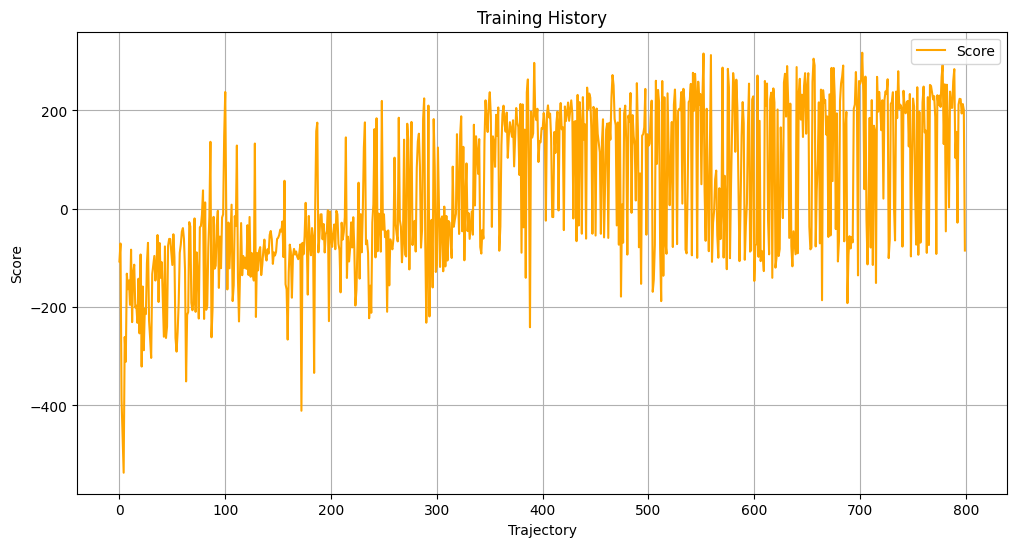

In [7]:
import matplotlib.pyplot as plt

# plot results
plt.figure(figsize=(12, 6))
plt.plot(reward_hist, label='Score', color="#FFA500")
plt.title('Training History')
plt.xlabel('Trajectory')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()